# Theory:

Compare timeseries with RC prediction

# Imports:

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import rescomp

# System:

### Lorenz iterator:

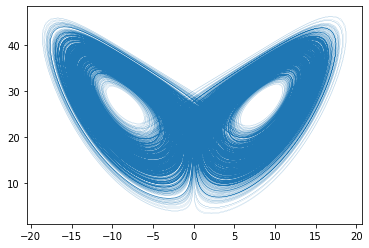

In [2]:
# Lorenz parameters:
dt_L = 0.01
starting_point_L = np.array([0, 1, 0])

# lorenz iterator:

def data_creation_function(time_steps, dt, starting_point):
    return rescomp.simulations.simulate_trajectory("lorenz", dt, time_steps, starting_point)

def f_L(x):
    return data_creation_function(2, dt_L, x)[-1]

# test lorenz iterator:
disc_steps = 1000
time_steps = 100000

time_series_all = np.zeros((time_steps+disc_steps, 3))
time_series_all[0, :] = starting_point_L

for i in range(1, time_steps+disc_steps):
    x_last = time_series_all[i - 1, :]
    time_series_all[i, :] = f_L(x_last)

time_series = time_series_all[disc_steps:, :]

plt.plot(time_series[:, 0], time_series[:, 2], linewidth=0.1)

# RC prediction:

In [3]:
train_steps = 2000
sync_steps = 300

# create network:
esn = rescomp.ESNWrapper()

np.random.seed(42)
esn.create_network(n_dim=500, n_rad=0.1, n_avg_deg=6.0,
                    n_type_flag="erdos_renyi", network_creation_attempts=10)

x_dim = time_series.shape[1]
esn.create_input_matrix(x_dim, w_in_scale=1.0, w_in_sparse=True, w_in_ordered=False)

# train and predict:
y_pred, y_test = esn.train_and_predict(time_series, train_sync_steps=sync_steps, train_steps=train_steps,
                                       w_out_fit_flag="linear_and_square_r_alt")

# Compare real vs. predicted time_series:

In [4]:
time = np.arange(0, y_pred.shape[0])*dt_L

## small times:

(0, 15)

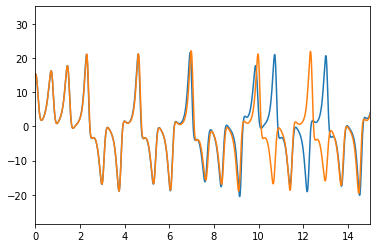

In [5]:
# Simple: plot some coordinates
ix = 1
plt.plot(time, y_test[:, ix])
plt.plot(time, y_pred[:, ix])

plt.xlim(0, 15)

(0, 15)

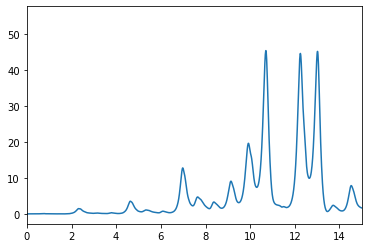

In [6]:
# plot the error over time:
error = rescomp.measures.error_over_time(y_pred, y_test)
plt.plot(time, error)
plt.xlim(0, 15)

## Attractor measures:

### Probability Density Function:

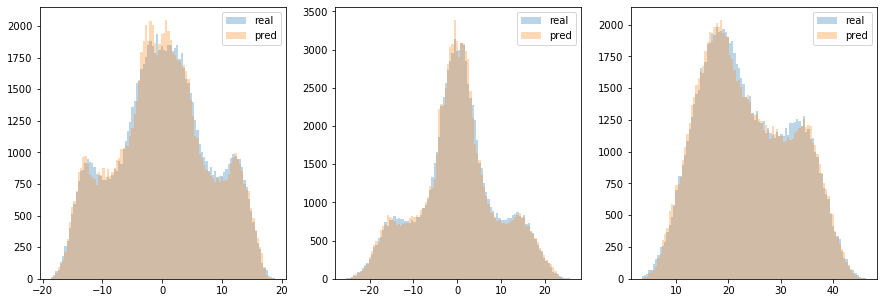

In [7]:
# PDE:
plt.figure(figsize=(15,5))

plt.subplot(131)
ix = 0

_, b, _ = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(132)
ix = 1
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

plt.subplot(133)
ix = 2
_, b, _  = plt.hist(y_test[:, ix], bins=100, alpha=0.3, label="real")
plt.hist(y_pred[:, ix], bins=b, alpha=0.3, label="pred")
plt.legend()

### Fourier Spectrum:

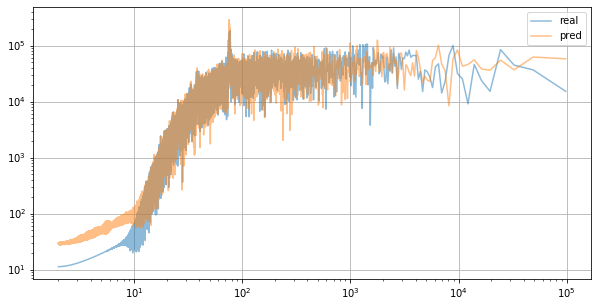

In [8]:
# Fourier Spectrum:
plt.figure(figsize=(10, 5))

x, y = rescomp.measures.fourier_spectrum(y_test, period=True)
plt.plot(x,y, label="real", alpha=0.5)
x, y = rescomp.measures.fourier_spectrum(y_pred, period=True)
plt.plot(x,y, label="pred", alpha=0.5)

# plt.xlim(-0.01, 0.02)
plt.yscale("log")
plt.xscale("log")
plt.grid()
plt.legend()

### Poincare Map:

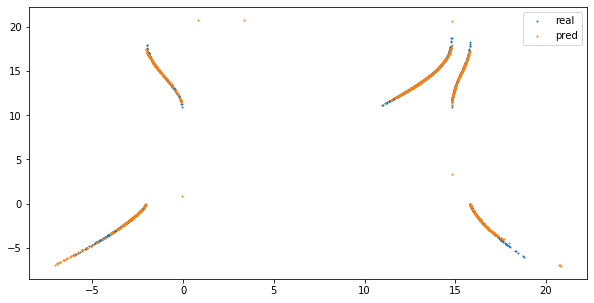

In [9]:
# Poincare Map:
ix = 0
mode="maxima"

plt.figure(figsize=(10, 5))

x, y = rescomp.measures.poincare_map(y_test, dimension=ix, mode=mode)
plt.scatter(x, y, label="real", s=1)

x, y = rescomp.measures.poincare_map(y_pred, dimension=ix, mode=mode)
plt.scatter(x, y, label="pred", s=1)

plt.legend()

### Correlation Dimension:

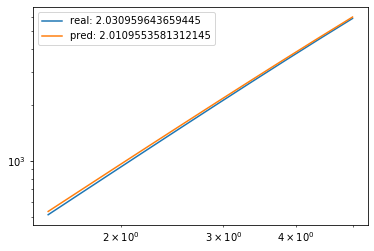

In [10]:
sloap, N_r = rescomp.measures.dimension(y_test, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"real: {sloap}")

sloap, N_r = rescomp.measures.dimension(y_pred, return_neighbours=True, nr_steps=10)
plt.loglog(N_r[0], N_r[1], label=f"pred: {sloap}")

plt.legend()

### Lyapunov spectrum:

#### Rosenberg Algorithm:

avg period: 3.55470680946905
For 0/97700 points, all 50 closest neighbours were temporally closer than 3.55470680946905 and thus not considered
For 901/97700 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 96799
avg period: 4.16532836674741
For 0/97700 points, all 50 closest neighbours were temporally closer than 4.16532836674741 and thus not considered
For 885/97700 points, there were not 500 steps left in the timeseries (either for the base and/or nn-point)
final number of points: 96815


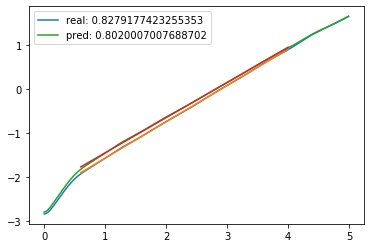

In [11]:
t_min, t_max = 0.6, 4
steps = 500

out = rescomp.measures.lyapunov_rosenstein(y_test, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"real: {coef[0]}")
plt.plot(x_fit, y_fit)

out = rescomp.measures.lyapunov_rosenstein(y_pred, dt=dt_L, steps=steps)
x_fit, y_fit, coef = rescomp.utilities._linear_fit(out[0], dt_L, t_min=t_min, t_max=t_max)
plt.plot(out[1], out[0], label=f"pred: {coef[0]}")
plt.plot(x_fit, y_fit)

plt.legend()

#### QR decomposition:

In [12]:
Nens = 5
N_dims = 5
np.random.seed(42)
starting_points = np.random.randn(Nens, 3)

In [13]:
# iterator of reservoir:
def f_res(x):
    return esn._predict_step(x)

In [14]:
out_real = rescomp.measures.calculate_divergence(f_L, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

out_res = rescomp.measures.calculate_divergence(f_res, starting_points=starting_points, T=10, tau=100, dt=dt_L, N_dims=N_dims, random_directions=True)

N_ens: 1/5
..calculating transient..
timestep 1000/1000
N_ens: 2/5
..calculating transient..
timestep 1000/1000
N_ens: 3/5
..calculating transient..
timestep 1000/1000
N_ens: 4/5
..calculating transient..
timestep 1000/1000
N_ens: 5/5
..calculating transient..
timestep 1000/1000
N_ens: 1/5
..calculating transient..
timestep 1000/1000
N_ens: 2/5
..calculating transient..
timestep 1000/1000
N_ens: 3/5
..calculating transient..
timestep 1000/1000
N_ens: 4/5
..calculating transient..
timestep 1000/1000
N_ens: 5/5
..calculating transient..
timestep 1000/1000


C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


(0, 1)

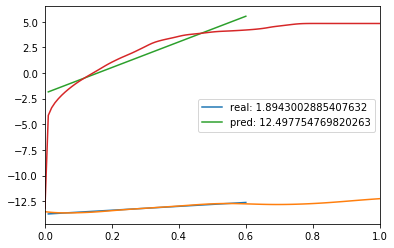

In [15]:
for out, label in zip((out_real, out_res), ("real", "pred")):
    y = np.log(out)
    y = np.mean(y, axis=-1)[:, 0]
    t = np.arange(0, y.size)*dt_L
    x_fit, y_fit, coef = rescomp.utilities._linear_fit(y, dt_L, t_min=0.01, t_max=0.6)
    plt.plot(x_fit, y_fit, label=f"{label}: {coef[0]}")
    plt.plot(t, y)
plt.legend()
plt.xlim(0, 1)
